## Table of Contents
* [Description of dataset columns and preferred formats](#first-section)
* [Loading data](#second-section)
* [Preliminary analysis of the dataset](#third-section)
* [Feature analysis and engineering](#fourth-section)
* [Splitting data into train, validation and test datasets](#fith-section)
* [Model training](#sixth-section)

## Description of dataset columns and preferred formats <a class="anchor" id="first-section"></a>

[Reference link](https://www.kaggle.com/xwolf12/malicious-and-benign-websites/discussion/54433)

***URL***: it is the anonimous identification of the URL analyzed in the study

***URL_LENGTH***: it is the number of characters in the URL

***NUMBER_SPECIAL_CHARACTERS***: it is number of special characters identified in the URL, such as, “/”, “%”, “#”, “&”, “. “, “=”

***CHARSET***: it is a categorical value and its meaning is the character encoding standard (also called character set).

***SERVER***: it is a categorical value and its meaning is the operative system of the server got from the packet response.

***CONTENT_LENGTH***: it represents the content size of the HTTP header.

***WHOIS_COUNTRY***: it is a categorical variable, its values are the countries we got from the server response (specifically, our script used the API of Whois).

***WHOIS_STATEPRO***: it is a categorical variable, its values are the states we got from the server response (specifically, our script used the API of Whois).

***WHOIS_REGDATE***: Whois provides the server registration date, so, this variable has date values with format DD/MM/YYY HH:MM

***WHOIS_UPDATED_DATE***: Through the Whois we got the last update date from the server analyzed

***TCP_CONVERSATION_EXCHANGE***: This variable is the number of TCP packets exchanged between the server and our honeypot client

***DIST_REMOTE_TCP_PORT***: it is the number of the ports detected and different to TCP

***REMOTE_IPS***: this variable has the total number of IPs connected to the honeypot

***APP_BYTES***: this is the number of bytes transfered

***SOURCE_APP_PACKETS***: packets sent from the honeypot to the server

***REMOTE_APP_PACKETS***: packets received from the server

***APP_PACKETS***: this is the total number of IP packets generated during the communication between the honeypot and the server

***DNS_QUERY_TIMES***: this is the number of DNS packets generated during the communication between the honeypot and the server

***TYPE***: this is a categorical variable, its values represent the type of web page analyzed, specifically, 1 is for malicious websites and 0 is for benign websites


### Column formats

Considering the above description, it is proposed to initially give folloiwng formats to columns:

**string**:
- *URL*, *CHARSET*, *SERVER*, *CONTENT_LENGTH*, *WHOIS_COUNTRY*, *WHOIS_STATEPRO* 

**string or date**:
- *WHOIS_REGDATE*, *WHOIS_UPDATED_DATE*

**numeric - int or float**:
- *URL_LENGTH*, *NUMBER_SPECIAL_CHARACTERS*, *CONTENT_LENGTH*, *TCP_CONVERSATION_EXCHANGE*, *DIST_REMOTE_TCP_PORT*, *REMOTE_IPS*, *APP_BYTES*, *SOURCE_APP_PACKETS*, *REMOTE_APP_PACKETS*, *SOURCE_APP_BYTES*, *REMOTE_APP_BYTES*, *APP_PACKETS*, *DNS_QUERY_TIMES*, *Type*

The chosen formats for columns may change after the **Feature engineering** and **Feature selection** phases.

## Loading data <a class="anchor" id="second-section"></a>

In [450]:
# importing general libraries
# other libraries will be imported later, upon demand
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


When reading a CSV table into Pandas with `read_csv()`, columns get formats that are derived by the function.
One can assign columns' formats using the `dtype` parameter. It is also possible to assign formats to a subset of columns.


If a column contains missing values, it cannot be assigned to `int`. It must be either `string` (i.e. `object` in Pandas terms) or `float`.
Therefore, we assign `string` format to several columns that we are sure about, including those that contain dates. 
For the rest of columns we let Pandas derive numeric formats. Numeric columns must have the period as the decimal value delimiter, ex. `3.1415`.

In [86]:
dtype_string_columns = {'URL': str,
                        'CHARSET': str,
                        'SERVER': str,
                        'WHOIS_COUNTRY': str,
                        'WHOIS_STATEPRO': str,
                        'WHOIS_REGDATE': str,
                        'WHOIS_UPDATED_DATE': str}

dtype_int_columns = {'NUMBER_SPECIAL_CHARACTERS': int,
                     'CONTENT_LENGTH': int,
                     'TCP_CONVERSATION_EXCHANGE': int,
                     'DIST_REMOTE_TCP_PORT': int,
                     'REMOTE_IPS': int,
                     'APP_BYTES': int,
                     'SOURCE_APP_PACKETS': int,
                     'REMOTE_APP_PACKETS': int,
                     'SOURCE_APP_BYTES': int,
                     'REMOTE_APP_BYTES': int,
                     'APP_PACKETS': int,
                     'DNS_QUERY_TIMES': int,
                     'Type': int}

dtype = {'URL': str,
         'URL_LENGTH': int,
         'NUMBER_SPECIAL_CHARACTERS': int,
         'CHARSET': str,
         'SERVER': str,
         'CONTENT_LENGTH': int,
         'WHOIS_COUNTRY': str,
         'WHOIS_STATEPRO': str,
         'WHOIS_REGDATE': str,
         'WHOIS_UPDATED_DATE': str,
         'TCP_CONVERSATION_EXCHANGE': int,
         'DIST_REMOTE_TCP_PORT': int,
         'REMOTE_IPS': int,
         'APP_BYTES': int,
         'SOURCE_APP_PACKETS': int,
         'REMOTE_APP_PACKETS': int,
         'SOURCE_APP_BYTES': int,
         'REMOTE_APP_BYTES': int,
         'APP_PACKETS': int,
         'DNS_QUERY_TIMES': int,
         'Type': int}


No errors were raised during data loading.

In [159]:
df_train = pd.read_csv("data/Train.csv",
                       header=0,
                       sep=",",
                       dtype=dtype_string_columns
                       )


## Preliminary analysis of the dataset <a class="anchor" id="third-section"></a>

Our training dataset contains 1431 rows and 21 columns; 20 predictor columns and 1 target.

In [88]:
# shape
df_train.shape


(1431, 21)

It looks like *URL* column serves as an index for observations and should not be used in training a model. Therefore, we can assume that there are 19 predictors. The numeric columns *CONTENT_LENGTH* and *DNS_QUERY_TIMES*, and string-based column *SERVER* contain missing values. **Data imputation** or **dropping the whole column** should be considered for these columns.

In [173]:
# missing values
df_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1431 entries, 0 to 1430
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   URL                        1431 non-null   object        
 1   URL_LENGTH                 1431 non-null   int64         
 2   NUMBER_SPECIAL_CHARACTERS  1431 non-null   int64         
 3   CHARSET                    1431 non-null   object        
 4   SERVER                     1430 non-null   object        
 5   CONTENT_LENGTH             786 non-null    float64       
 6   WHOIS_COUNTRY              1431 non-null   object        
 7   WHOIS_STATEPRO             1431 non-null   object        
 8   WHOIS_REGDATE              1431 non-null   object        
 9   WHOIS_UPDATED_DATE         1431 non-null   object        
 10  TCP_CONVERSATION_EXCHANGE  1431 non-null   int64         
 11  DIST_REMOTE_TCP_PORT       1431 non-null   int64         
 12  REMOTE

We can see that the dataset is imbalanced. Only about `11%` of observations belong to the `positive` class. One should take this into account when splitting data into train, validation and test subsets as well as during cross-validation. It is also possible to try some re-sampling methods to balance the classes (upsampling or undersampling). 

In [92]:
df_train.Type.value_counts(normalize=True).round(2)


0    0.89
1    0.11
Name: Type, dtype: float64

### Pair plot
It is possible to create a scatter plot for every pair of numeric features. The `pairplot()` function of the `Seaborn` library gives such a graph. Using different colors for dots of different target classes, one can 
visualize if the two classes are separable. 

Since the input table is not large, we can use the `pairplot()` function on the whole dataset. However, generating this plot is a demanding task and may take a long time.

In [19]:
# sns.pairplot(df_train, hue='Type')


# Feature analysis and engineering  <a class="anchor" id="fourth-section"></a>

## Formatting datetime columns
Original datetime columns have different string formats. Also they contain non-datetime values that need to be processed. We use string-length of datetime values to differentiate between formats and to find non-datetime values.

In [168]:
df_train[['WHOIS_REGDATE', 'WHOIS_UPDATED_DATE']].head()


,WHOIS_REGDATE,WHOIS_UPDATED_DATE
0,None,None
1,None,None
2,7/10/1997 4:00,12/09/2013 0:45
3,12/05/1996 0:00,11/04/2017 0:00
4,3/08/2016 14:30,3/10/2016 3:45


In [176]:
df_train['WHOIS_REGDATE'].apply(lambda x: len(x)).value_counts()


15    939
14    365
4      89
16     30
22      5
1       3
Name: WHOIS_REGDATE, dtype: int64

In [162]:
df_train['WHOIS_UPDATED_DATE'].apply(lambda x: len(x)).value_counts()


15    843
14    384
16    103
4      96
22      5
Name: WHOIS_UPDATED_DATE, dtype: int64

In [101]:
non_date_values = set([s for s in df_train.WHOIS_REGDATE.values if len(s) < 6])
non_date_values = non_date_values.union(
    set([s for s in df_train.WHOIS_UPDATED_DATE.values if len(s) < 6]))
print(non_date_values)


{'b', '0', 'None'}


There are basically two date formats in the columns: `'%Y-%m-%dT%H:%M:%S.0Z'` and `'%d/%m/%Y %H:%M'`. The last one should always have length 16 to be properly read by the `pd.to_datetime()` function, but there are values with length 14 and 15. Values that have length 1 or 4 are missing values. We need to transform the date values to have correct string format.

In [174]:
def transform_dates(df, col):
    """
    Transforms date values from different string formats to '%d/%m/%Y %H:%M'.
    Uses string length of a given value as the basic parameter.
    Input: dataframe and name of the column to be transformed.
    Returns: list of date values in '%d/%m/%Y %H:%M' format.

    Examples of possible input values '12/05/1996 0:00', '3/08/2016 14:30',
    '7/10/1997 4:00', '2017-03-07T22:02:38.0Z'. Other inputs will be defauled to
    '31/12/1960 23:59'.
    """
    new_date_vals = []
    for date in df[col]:
        if len(date) == 14:  # ex. '7/10/1997 4:00'
            day_ = '0' + date.split(' ')[0]
            time_ = '0' + date.split(' ')[1]
            date_ = day_ + ' '+time_
        elif len(date) == 15:  # ex. '12/05/1996 0:00', '3/08/2016 14:30'
            day_ = date.split(' ')[0]
            time_ = date.split(' ')[1]
            if len(time_) == 4:  # ex. 0:00
                time_ = '0' + time_
            else:
                day_ = '0' + day_
            date_ = day_ + ' '+time_
        elif len(date) == 22:  # ex. '2017-03-07T22:02:38.0Z'
            date_ = date[8:10]+'/'+date[5:7]+'/'+date[:4]+' '+date[11:16]
        elif len(date) == 16:  # ex. '12/09/2013 0:45', these should not be changed
            date_ = date
        else:
            date_ = '31/12/1960 23:59'
        new_date_vals.append(date_)
    df[col+'_TS'] = pd.to_datetime(new_date_vals)


In [164]:
transform_dates(df=df_train, col='WHOIS_REGDATE')
transform_dates(df=df_train, col='WHOIS_UPDATED_DATE')


Original columns with date values contain missing values. They are transformed by the `transform_dates()` function into `1969-12-31 23:59:00`. However, one should not forget that these values were obtained from missing ones. One possible way to handle this is to create a new column that would indicate whether a respective original date column has a missing value.

In [167]:
# having a look at theoriginal and modified date columns
date_cols = ['WHOIS_REGDATE', 'WHOIS_UPDATED_DATE',
             'WHOIS_REGDATE_TS', 'WHOIS_UPDATED_DATE_TS']
df_train[date_cols].head()


,WHOIS_REGDATE,WHOIS_UPDATED_DATE,WHOIS_REGDATE_TS,WHOIS_UPDATED_DATE_TS
0,None,None,1960-12-31 23:59:00,1960-12-31 23:59:00
1,None,None,1960-12-31 23:59:00,1960-12-31 23:59:00
2,7/10/1997 4:00,12/09/2013 0:45,1997-07-10 04:00:00,2013-12-09 00:45:00
3,12/05/1996 0:00,11/04/2017 0:00,1996-12-05 00:00:00,2017-11-04 00:00:00
4,3/08/2016 14:30,3/10/2016 3:45,2016-03-08 14:30:00,2016-03-10 03:45:00


In [171]:
# number of missing values in the date columns
# these should be taken into account as well
(df_train[['WHOIS_REGDATE_TS', 'WHOIS_UPDATED_DATE_TS']]
 == '1960-12-31 23:59:00').sum()


WHOIS_REGDATE_TS         92
WHOIS_UPDATED_DATE_TS    96
dtype: int64

## Choosing columns to model with

In this section, we would like to make a preliminary selection of columns. The decision whether to drop a column from further consideration will be based on practical reasons such as:
- column contains either too many or too few unique values
- column contains many missing values
- column contains a lot of unstructured text
- categorical column contains too many categories, and encoding leads to large memory usage
- numeric column correlates well with another column or columns

In [189]:
# list of columns, their data types, amount of missing values in float64-type columns
df_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1431 entries, 0 to 1430
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   URL                        1431 non-null   object        
 1   URL_LENGTH                 1431 non-null   int64         
 2   NUMBER_SPECIAL_CHARACTERS  1431 non-null   int64         
 3   CHARSET                    1431 non-null   object        
 4   SERVER                     1430 non-null   object        
 5   CONTENT_LENGTH             786 non-null    float64       
 6   WHOIS_COUNTRY              1431 non-null   object        
 7   WHOIS_STATEPRO             1431 non-null   object        
 8   WHOIS_REGDATE              1431 non-null   object        
 9   WHOIS_UPDATED_DATE         1431 non-null   object        
 10  TCP_CONVERSATION_EXCHANGE  1431 non-null   int64         
 11  DIST_REMOTE_TCP_PORT       1431 non-null   int64         
 12  REMOTE

Having a look at the number of unique values in columns can also be interesting. It may help to decide which columns to remove from consideration, for example constant columns. 

Looking at the number of unique values in combination with the `target` column, can help to understand if columns have valuable information for distinguishing between `positives` and `negatives`. Here we can see that the column *CHARSET* has 9 unique values in total. Almost all unique values are present in both target classes.
On the other hand, the columns like *SERVER* may be good for differentiating between the target classes. They have many unique values, but only some of them are present in the `positive` class.

In [172]:
# unique values
d_unique_vals = {}
for col in df_train.columns.tolist():
    d_unique_vals[col] = df_train[col].nunique()

(df_train.groupby('Type').nunique().T.
 merge(pd.Series(d_unique_vals, name='unique_vals'),
       right_index=True, left_index=True)
 )


,0,1,unique_vals
URL,1272,159,1431
URL_LENGTH,124,68,135
NUMBER_SPECIAL_CHARACTERS,26,24,29
CHARSET,8,7,9
SERVER,231,27,239
CONTENT_LENGTH,500,48,540
WHOIS_COUNTRY,42,21,49
WHOIS_STATEPRO,164,36,182
WHOIS_REGDATE,720,54,769
WHOIS_UPDATED_DATE,519,49,542


### Categorical features

There are 7 string-based columns in the dataset.

In [269]:
df_train.select_dtypes(exclude=['number', 'datetime'])

,URL,CHARSET,SERVER,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE
0,B0_2314,UTF-8,Apache/2.4.10,None,None,None,None
1,B0_911,us-ascii,Microsoft-HTTPAPI/2.0,None,None,None,None
2,B0_113,ISO-8859-1,nginx,US,AK,7/10/1997 4:00,12/09/2013 0:45
3,B0_403,UTF-8,None,US,TX,12/05/1996 0:00,11/04/2017 0:00
4,B0_2064,UTF-8,nginx,SC,Mahe,3/08/2016 14:30,3/10/2016 3:45
...,...,...,...,...,...,...,...
1426,M4_45,UTF-8,Apache,ES,Barcelona,17/09/2008 0:00,2/09/2016 0:00
1427,M4_48,UTF-8,Apache,ES,Barcelona,17/09/2008 0:00,2/09/2016 0:00
1428,B0_162,utf-8,Apache/2.2.16 (Debian),US,FL,15/02/1999 0:00,15/07/2015 0:00
1429,B0_1152,ISO-8859-1,cloudflare-nginx,US,CA,1/04/1998 0:00,9/12/2016 0:00


The colunm *URL* has as many values as the rows. Therefore we will treat this column as the index and will not use it for modell training. 

We will not use *WHOIS_REGDATE* and *WHOIS_UPDATED_DATE* columns further. We found a way how to format them into datetime: *WHOIS_REGDATE_TS* and *WHOIS_UPDATED_DATE_TS*. However, in the new datasets these columns may have values that are not covered by our formatting. Therefore using them may lead to faults.

In [187]:
df_train['URL'].nunique()


1431

*CHARSET* has both lowercase and uppercase versions values same values. It contains in fact 7 unique values. If we will use this column, we will make an uppercase varsion of it, one-hot-encode it and ignore unseen new values.

In [296]:
df_train['CHARSET'].str.upper().value_counts()


UTF-8           837
ISO-8859-1      461
US-ASCII        124
NONE              6
WINDOWS-1251      1
ISO-8859          1
WINDOWS-1252      1
Name: CHARSET, dtype: int64

In [303]:
df_train.groupby('Type')['CHARSET'].value_counts().unstack().T


Type,0,1
CHARSET,,
ISO-8859,1.0,NaN
ISO-8859-1,311.0,39.0
None,5.0,1.0
UTF-8,448.0,92.0
iso-8859-1,101.0,10.0
us-ascii,121.0,3.0
utf-8,284.0,13.0
windows-1251,NaN,1.0
windows-1252,1.0,NaN


*SERVER* contains many different values that are very unstructured. One could use the length of the servername or another representation of this feature.

In [235]:
df_train['SERVER_LENGTH'] = df_train['SERVER'].apply(lambda x: len(str(x)))


In [199]:
df_train['SERVER'].sort_values().unique()

array(['.V01 Apache', '294', 'ATS', 'ATS/5.3.0',
       'Aeria Games & Entertainment', 'AkamaiGHost', 'AmazonS3', 'Apache',
       'Apache-Coyote/1.1',
       'Apache/1.3.27 (Unix)  (Red-Hat/Linux) mod_perl/1.26 PHP/4.3.3 FrontPage/5.0.2 mod_ssl/2.8.12 OpenSSL/0.9.6b',
       'Apache/1.3.27 (Unix) PHP/4.4.1',
       'Apache/1.3.31 (Unix) PHP/4.3.9 mod_perl/1.29 rus/PL30.20',
       'Apache/1.3.33 (Unix) mod_ssl/2.8.24 OpenSSL/0.9.7e-p1 PHP/4.4.8',
       'Apache/1.3.34 (Unix) PHP/4.4.4',
       'Apache/1.3.37 (Unix) mod_perl/1.29 mod_ssl/2.8.28 OpenSSL/0.9.7e-p1',
       'Apache/1.3.39 (Unix) PHP/5.2.5 mod_auth_passthrough/1.8 mod_bwlimited/1.4 mod_log_bytes/1.2 mod_gzip/1.3.26.1a FrontPage/5.0.2.2635 DAV/1.0.3 mod_ssl/2.8.30 OpenSSL/0.9.7a',
       'Apache/1.3.42 Ben-SSL/1.60 (Unix) mod_gzip/1.3.26.1a mod_fastcgi/2.4.6 mod_throttle/3.1.2 Chili!Soft-ASP/3.6.2 FrontPage/5.0.2.2635 mod_perl/1.31 PHP/4.4.9',
       'Apache/2', 'Apache/2.0.52 (Red Hat)',
       'Apache/2.0.63 (Unix) mod_ss

*WHOIS_COUNTRY* has both lowercase and uppercase versions values same values. There are in fact 44 unique values, 211 observations are missing the country.

In [271]:
df_train['WHOIS_COUNTRY'].sort_values().unique()
# {'UK': ["[U'GB'; U'UK']", "UNITED KINGDOM"],
#  'CY': "CYPRUS" }


array(['AE', 'AT', 'AU', 'BE', 'BR', 'BS', 'BY', 'CA', 'CH', 'CN', 'CZ',
       'Cyprus', 'DE', 'ES', 'FR', 'GB', 'HK', 'IE', 'IL', 'IN', 'IT',
       'JP', 'KG', 'KR', 'KY', 'LU', 'LV', 'NL', 'NO', 'None', 'PA', 'PH',
       'PK', 'RU', 'SC', 'SE', 'SI', 'TH', 'TR', 'UA', 'UG', 'UK', 'US',
       'UY', 'United Kingdom', "[u'GB'; u'UK']", 'ru', 'se', 'us'],
      dtype=object)

In [270]:
# 44 unique values if we exclude "[U'GB'; U'UK']", "UNITED KINGDOM"
df_train['WHOIS_COUNTRY'].str.upper().nunique()


46

In [185]:
df_train['WHOIS_COUNTRY'].str.upper().value_counts()


US                899
NONE              211
CA                 76
ES                 42
AU                 30
GB                 17
PA                 15
JP                 11
CN                 10
IN                 10
CZ                  8
UK                  8
FR                  6
NL                  6
CH                  6
RU                  6
[U'GB'; U'UK']      5
KR                  5
AT                  4
BS                  4
PH                  4
SE                  4
KY                  3
TR                  3
SC                  3
DE                  3
HK                  3
BE                  3
KG                  2
CYPRUS              2
UY                  2
BR                  2
IL                  2
UA                  2
NO                  2
SI                  2
IE                  1
AE                  1
BY                  1
LV                  1
IT                  1
PK                  1
LU                  1
TH                  1
UG                  1
UNITED KIN

In [313]:
# df_train.groupby('WHOIS_COUNTRY')['Type'].mean()


*WHOIS_STATEPRO* is very mixed. It would be difficult to use it directly for modelling. However, one could create new features using some hasing techniques, as in [link](https://www.kaggle.com/evgenyparenchenkov/svm-catboost-and-a-couple-of-new-features).

In [197]:
df_train['WHOIS_STATEPRO'].sort_values().unique()


array(['-', '--', '6110021', 'AB', 'AK', 'AL', 'ALABAMA', 'ALBERTA',
       'ANTWERP', 'AZ', 'Alabama', 'Alicante', 'Andhra Pradesh',
       'Arizona', 'Arkansas', 'Austria', 'BC', 'Barcelona', 'Bei Jing',
       'Berlin', 'British Columbia', 'CA', 'CALIFORNIA', 'CH', 'CO',
       'CO. DUBLIN', 'CT', 'California', 'Central', 'Colorado',
       'Connecticut', 'DC', 'DE', 'District of Columbia', 'Dubai', 'FL',
       'FLORIDA', 'Florida', 'Fukuoka', 'GA', 'GRAND CAYMAN',
       'Greater London', 'HANTS', 'HR', 'Haryana', 'IL',
       'ILOCOS NORTE R3', 'INDAL', 'Illinois', 'Indiana', 'KG', 'KS',
       'Kansas', 'Karnataka', 'Kentucky', 'Krasnoyarsk', 'LA', 'London',
       'MA', 'MAHARASHTR', 'MAINE', 'MB', 'MD', 'ME', 'MH', 'MI',
       'MIDDLESEX', 'MO', 'MOSCOW', 'Maharashtra', 'Mahe', 'Maine',
       'Manila', 'Manitoba', 'Maryland', 'Massachusetts', 'Metro Manila',
       'Michigan', 'Minnesota', 'Missouri', 'Montevideo', 'NC',
       'NEW SOUTH WALES', 'NEW YORK', 'NH', 'NJ', 'NON

In [337]:
usable_categorical_columns = ['WHOIS_COUNTRY']


### Numeric features

There are 14 numeric columns, including new feature *SERVER_LENGTH*, and 1 target column.

In [284]:
df_train.select_dtypes(include=['number'])


,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CONTENT_LENGTH,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type,SERVER_LENGTH
0,16,6,15087.0,17,7,4,1230,17,19,1265,1230,17,0.0,0,13
1,16,6,324.0,0,0,0,0,0,0,0,0,0,0.0,0,21
2,17,6,162.0,31,22,3,3812,39,37,18784,4380,39,8.0,0,5
3,17,6,124140.0,57,2,5,4278,61,62,129889,4586,61,4.0,0,4
4,18,7,NaN,11,6,9,894,11,13,838,894,11,0.0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1426,194,17,NaN,0,0,0,0,0,3,186,0,0,0.0,1,6
1427,194,16,NaN,0,0,0,0,0,3,186,0,0,0.0,1,6
1428,201,34,8904.0,83,2,6,6631,87,89,132181,6945,87,4.0,0,22
1429,234,34,NaN,0,0,0,0,0,0,0,0,0,0.0,0,16


In [290]:
# list of numeric columns
numeric_columns = df_train.select_dtypes(include=['number']).columns.tolist()


#### Correlation

Let us have a look at their correlation. 

As we can see there are some very correlated columns like *APP_PACKETS* and *DIST_REMOTE_TCP_PORT*. Here we consider linear correlation. In general, correlated features should not be used in model training, especially for linear models like `Logistic Regression`. However, for tree-based methods correlation is not a big problem. 

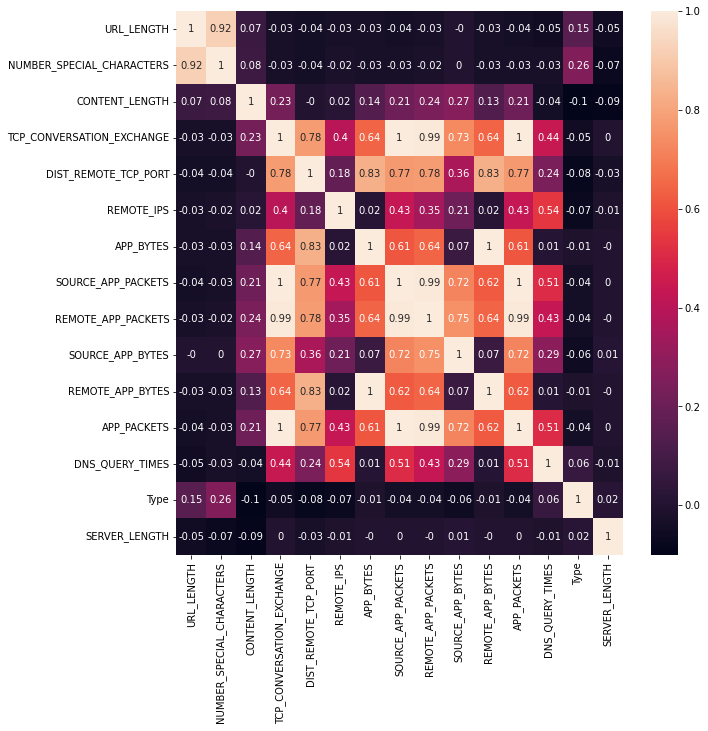

In [330]:
fig = plt.figure(figsize=(10, 10))
sns.heatmap(df_train[numeric_columns].corr().round(2), annot=True, fmt='g')
plt.show()


Setting some upper bound on correlation between features can be a good idea. If one of two correlated columns is used, the other one should not.

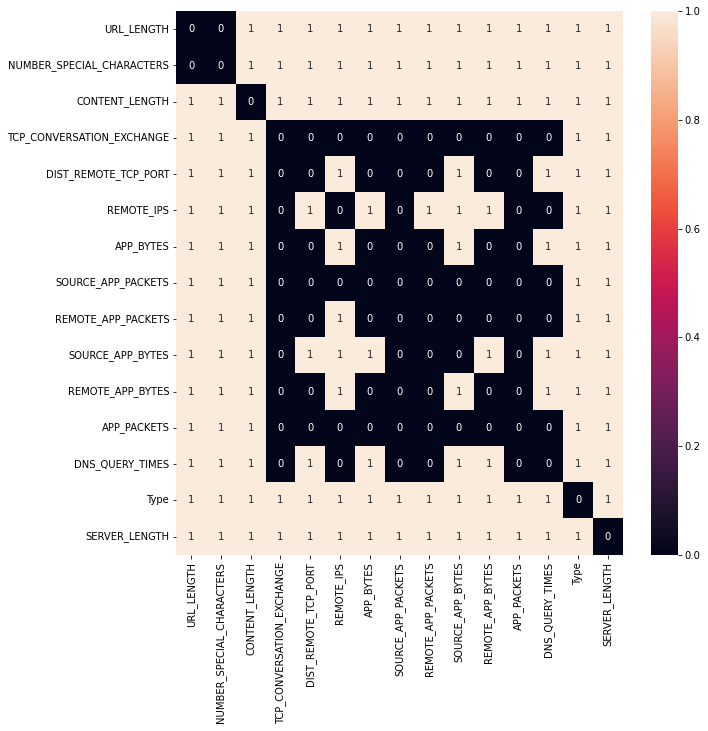

In [331]:
# Looking at numeric columns where absolute values of correlation are smaller than 0.4.
# In this representation, it is easier to see which columns should not be used together
# because of correlation. For example, 'URL_LENGTH' should not be use with 'NUMBER_SPECIAL_CHARACTERS'.

fig = plt.figure(figsize=(10, 10))
sns.heatmap((df_train[numeric_columns].corr().round(
    2).abs() < 0.4), annot=True, fmt='g')
plt.show()


Based on this correlation heatmap, one can decide to use *NUMBER_SPECIAL_CHARACTERS*, *REMOTE_IPS*, *SOURCE_APP_BYTES*, *REMOTE_APP_BYTES*, *SERVER_LENGTH* together because they do not correlate too much. *CONTENT_LENGTH* can also be in this list, but it has too many missing values.

In [319]:
usable_numeric_columns = ['NUMBER_SPECIAL_CHARACTERS', 'REMOTE_IPS',
                          'SOURCE_APP_BYTES', 'REMOTE_APP_BYTES', 'SERVER_LENGTH']


In [288]:
# idx_non_correlated_columns=(df_train[numeric_columns].corr().round(2).abs()< 0.4).values


#### Distribution

Numeric columns in the dataset have diverse ranges and distributions. Transformations like `Standard Scaling` and `Normalization` should be made when using these columns for modelling. We also can see that distributions for `positive` and `negative` classes to not differ a lot. It may be interesting to try polynomial transformation for these features and see how they would behave as predictors.

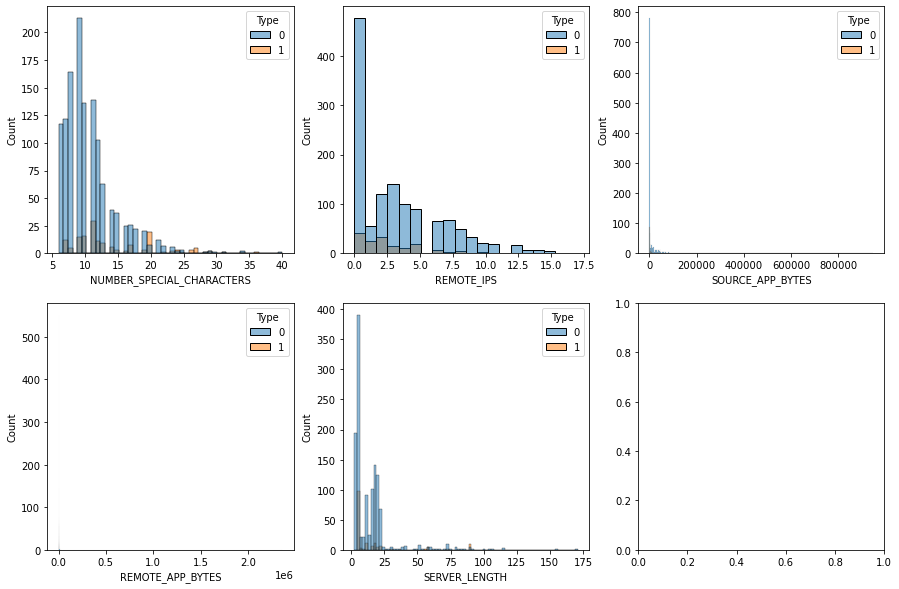

In [322]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax = ax.flatten()

for i, col in enumerate(usable_numeric_columns):
    sns.histplot(df_train, x=col, hue='Type', ax=ax[i])


### Datetime features

ML algorithms implemented in `scikit-learn` do not process datetime values. They need to be transformed into `numeric` format. Also one could deduce the day and month values from these features, and analyse if they do give any improvement for a model's predictive power.

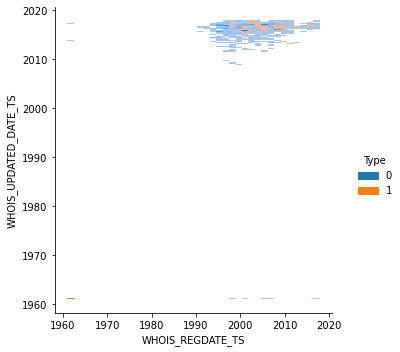

In [349]:
sns.displot(df_train, x='WHOIS_REGDATE_TS',
            y='WHOIS_UPDATED_DATE_TS', hue='Type')


In [463]:
# converting dates to int
df_train['WHOIS_REGDATE_INT'] = df_train['WHOIS_REGDATE_TS'].view(int)
df_train['WHOIS_UPDATED_DATE_INT'] = df_train['WHOIS_UPDATED_DATE_TS'].view(
    int)

# extracting month values
df_train['WHOIS_REGDATE_MONTH'] = df_train['WHOIS_REGDATE_TS'].dt.month
df_train['WHOIS_UPDATED_DATE_MONTH'] = df_train['WHOIS_UPDATED_DATE_TS'].dt.month

# extracting day values
df_train['WHOIS_REGDATE_DAY'] = df_train['WHOIS_REGDATE_TS'].dt.day
df_train['WHOIS_UPDATED_DATE_DAY'] = df_train['WHOIS_UPDATED_DATE_TS'].dt.day


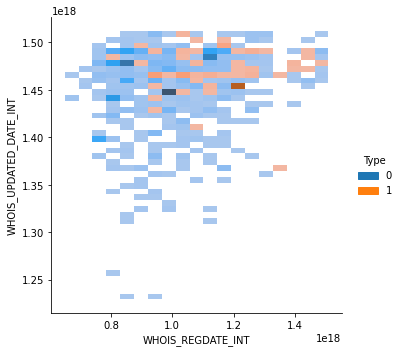

In [401]:
# this plot is a scatterplot of two features where dots are colored after the 'Type' variable
sns.displot(df_train.query('WHOIS_REGDATE_INT>0 and WHOIS_UPDATED_DATE_INT>0'),
            x='WHOIS_REGDATE_INT', y='WHOIS_UPDATED_DATE_INT', hue='Type')


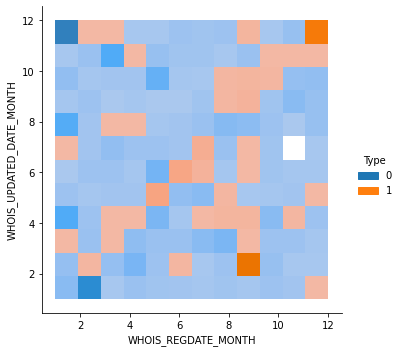

In [425]:
# this plot is a scatterplot of two features where dots are colored after the 'Type' variable
sns.displot(df_train, x='WHOIS_REGDATE_MONTH',
            y='WHOIS_UPDATED_DATE_MONTH', hue='Type')


Looking at linear correlation between deduced columns and the target. 

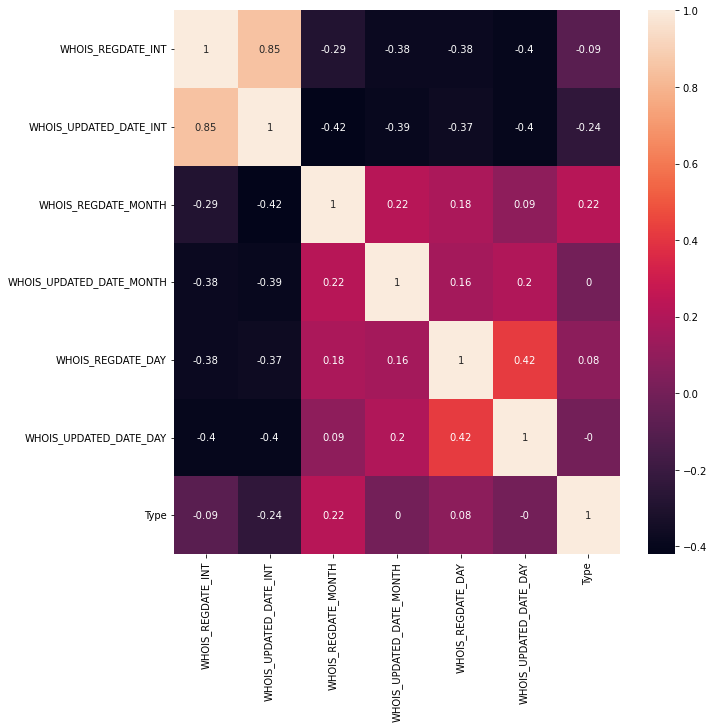

In [467]:
deduced_date_columns = ['WHOIS_REGDATE_INT', 'WHOIS_UPDATED_DATE_INT', 'WHOIS_REGDATE_MONTH',
                        'WHOIS_UPDATED_DATE_MONTH', 'WHOIS_REGDATE_DAY', 'WHOIS_UPDATED_DATE_DAY']
fig = plt.figure(figsize=(10, 10))
sns.heatmap(df_train[deduced_date_columns+['Type']
                     ].corr().round(2), annot=True, fmt='g')
plt.show()


The columns *SOURCE_APP_BYTES* and *REMOTE_APP_BYTES* have too large values. Therefore it could be relevant to use the `log()` function on them. To avoid getting `-inf` on zeros in the coulmns, we could shift them by adding 1. 

In [342]:
bytes_cols = []
for col in ['SOURCE_APP_BYTES', 'REMOTE_APP_BYTES']:
    df_train[col+'_LOG'] = (df_train[col]+1).apply(np.log)
    bytes_cols.append(col+'_LOG')


### Columns to drop 
- *URL*, *WHOIS_REGDATE*, *WHOIS_UPDATED_DATE* have been discussed before.
- *CONTENT_LENGTH* has too many missing values and it correlates with several other columns. Therefore I choose to drop it. 
- *CHARSET*, *DNS_QUERY_TIMES* too few unique values.
- *WHOIS_STATEPRO*, *SERVER* have too many unstructured values.
- We drop *URL_LENGTH* because correlates well with *NUMBER_SPECIAL_CHARACTERS* and the latter has better correlation with the target. 

We will also avoid using datetime columns here. Because their values may not be transformed appropriately and throw errors. This will also make our dataset transformation pipeline easier.

In [347]:
drop_columns = ['URL', 'WHOIS_REGDATE', 'WHOIS_UPDATED_DATE', 'CONTENT_LENGTH', 'CHARSET', 'DNS_QUERY_TIMES', 'WHOIS_STATEPRO', 'SERVER',
                'URL_LENGTH']


In [336]:
df_train.drop(columns=drop_columns)


,NUMBER_SPECIAL_CHARACTERS,WHOIS_COUNTRY,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,Type,WHOIS_REGDATE_TS,WHOIS_UPDATED_DATE_TS,SERVER_LENGTH,APP_BYTES_LOG,SOURCE_APP_BYTES_LOG,REMOTE_APP_BYTES_LOG
0,6,None,17,7,4,1230,17,19,1265,1230,17,0,1960-12-31 23:59:00,1960-12-31 23:59:00,13,7.115582,7.143618,7.115582
1,6,None,0,0,0,0,0,0,0,0,0,0,1960-12-31 23:59:00,1960-12-31 23:59:00,21,0.000000,0.000000,0.000000
2,6,US,31,22,3,3812,39,37,18784,4380,39,0,1997-07-10 04:00:00,2013-12-09 00:45:00,5,8.246172,9.840814,8.385032
3,6,US,57,2,5,4278,61,62,129889,4586,61,0,1996-12-05 00:00:00,2017-11-04 00:00:00,4,8.361475,11.774443,8.430981
4,7,SC,11,6,9,894,11,13,838,894,11,0,2016-03-08 14:30:00,2016-03-10 03:45:00,5,6.796824,6.732211,6.796824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1426,17,ES,0,0,0,0,0,3,186,0,0,1,2008-09-17 00:00:00,2016-02-09 00:00:00,6,0.000000,5.231109,0.000000
1427,16,ES,0,0,0,0,0,3,186,0,0,1,2008-09-17 00:00:00,2016-02-09 00:00:00,6,0.000000,5.231109,0.000000
1428,34,US,83,2,6,6631,87,89,132181,6945,87,0,1999-02-15 00:00:00,2015-07-15 00:00:00,22,8.799662,11.791935,8.845921
1429,34,US,0,0,0,0,0,0,0,0,0,0,1998-01-04 00:00:00,2016-09-12 00:00:00,16,0.000000,0.000000,0.000000


### Columns to use 

The way we chose these columns is not advanced in any way. One could use statistical tests, weights of evidence or other sophisticated methods. However, this is a simple approach that can work fine in this project.

In [426]:
use_columns = ['WHOIS_COUNTRY',
               'NUMBER_SPECIAL_CHARACTERS',
               'REMOTE_IPS',
               'SERVER_LENGTH',
               'SOURCE_APP_BYTES_LOG',
               'REMOTE_APP_BYTES_LOG'
               ]


## Splitting data into train, validation and test datasets <a class="anchor" id="fith-section"></a>

Since the dataset is not very large we will only holdout 20% (287 observations) of if for test. The rest of it, 1144 observations, will be used for training with cross-validation.

In [457]:
from sklearn.model_selection import train_test_split
X = df_train[use_columns]
y = df_train['Type']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y,
                                                    test_size=0.2,
                                                    random_state=0)


In [462]:
X_train.shape


(1144, 10)

In [445]:
X


,WHOIS_COUNTRY,NUMBER_SPECIAL_CHARACTERS,REMOTE_IPS,WHOIS_REGDATE_TS,WHOIS_UPDATED_DATE_TS,SERVER_LENGTH,SOURCE_APP_BYTES_LOG,REMOTE_APP_BYTES_LOG,WHOIS_REGDATE_MONTH,WHOIS_UPDATED_DATE_MONTH
0,None,6,4,1960-12-31 23:59:00,1960-12-31 23:59:00,13,7.143618,7.115582,12,12
1,None,6,0,1960-12-31 23:59:00,1960-12-31 23:59:00,21,0.000000,0.000000,12,12
2,US,6,3,1997-07-10 04:00:00,2013-12-09 00:45:00,5,9.840814,8.385032,7,12
3,US,6,5,1996-12-05 00:00:00,2017-11-04 00:00:00,4,11.774443,8.430981,12,11
4,SC,7,9,2016-03-08 14:30:00,2016-03-10 03:45:00,5,6.732211,6.796824,3,3
...,...,...,...,...,...,...,...,...,...,...
1426,ES,17,0,2008-09-17 00:00:00,2016-02-09 00:00:00,6,5.231109,0.000000,9,2
1427,ES,16,0,2008-09-17 00:00:00,2016-02-09 00:00:00,6,5.231109,0.000000,9,2
1428,US,34,6,1999-02-15 00:00:00,2015-07-15 00:00:00,22,11.791935,8.845921,2,7
1429,US,34,0,1998-01-04 00:00:00,2016-09-12 00:00:00,16,0.000000,0.000000,1,9


In [446]:
X.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1431 entries, 0 to 1430
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   WHOIS_COUNTRY              1431 non-null   object        
 1   NUMBER_SPECIAL_CHARACTERS  1431 non-null   int64         
 2   REMOTE_IPS                 1431 non-null   int64         
 3   WHOIS_REGDATE_TS           1431 non-null   datetime64[ns]
 4   WHOIS_UPDATED_DATE_TS      1431 non-null   datetime64[ns]
 5   SERVER_LENGTH              1431 non-null   int64         
 6   SOURCE_APP_BYTES_LOG       1431 non-null   float64       
 7   REMOTE_APP_BYTES_LOG       1431 non-null   float64       
 8   WHOIS_REGDATE_MONTH        1431 non-null   int64         
 9   WHOIS_UPDATED_DATE_MONTH   1431 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(5), object(1)
memory usage: 111.9+ KB


## Model training <a class="anchor" id="sixth-section"></a>

In [447]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
clf = DecisionTreeClassifier(max_depth=10, random_state=0)

numeric_features = ['NUMBER_SPECIAL_CHARACTERS',
                    'REMOTE_IPS',
                    'SERVER_LENGTH',
                    'SOURCE_APP_BYTES_LOG',
                    'REMOTE_APP_BYTES_LOG']

numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

# , 'WHOIS_REGDATE_MONTH', 'WHOIS_UPDATED_DATE_MONTH']
categorical_features = ['WHOIS_COUNTRY']
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(
    steps=[("preprocessor", preprocessor),
           ("classifier", LogisticRegression(random_state=0))]
)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))


model score: 0.934


# Model training

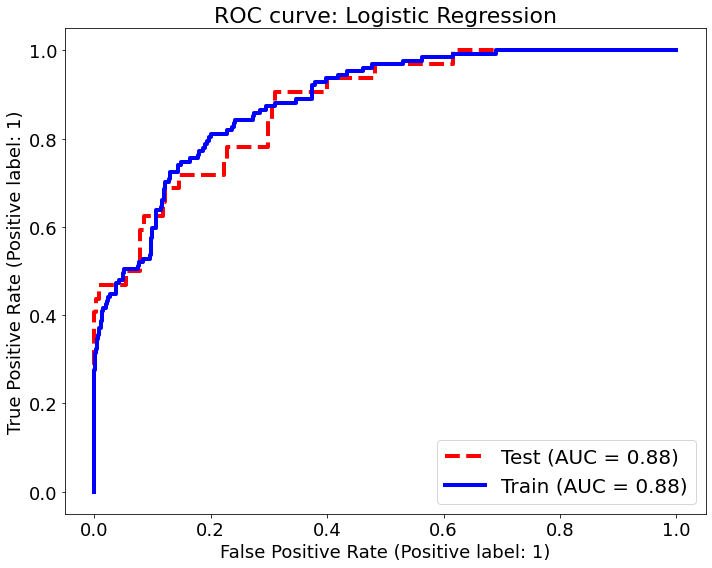

In [451]:
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import auc


def plot_roc_curves(clf, modelname):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
    plot_roc_curve(clf, X_test, y_test, ax=ax,
                   name='Test', lw=4, ls='--', c='r')
    plot_roc_curve(clf, X_train, y_train, ax=ax,
                   name='Train', lw=4, ls='-', c='b')
    ax.set_title('ROC curve: '+modelname, fontsize=22)
    for item in ([ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(18)
    plt.tight_layout()
    plt.legend(loc=4, fontsize=20)
    plt.show()


plot_roc_curves(clf, modelname='Logistic Regression')


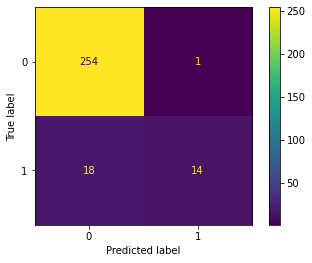

In [452]:
plot_confusion_matrix(estimator=clf, X=X_test, y_true=y_test)


# Model evaluation

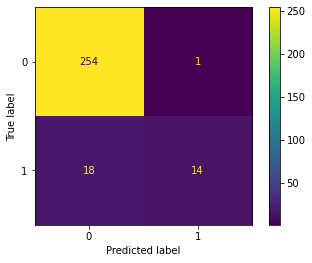

In [453]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
predictions = clf.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()

plt.show()


# Prediction and Saving results